# `geom_hex()`

In [1]:
from math import sqrt

import pandas as pd

from lets_plot import *


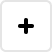
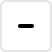
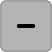
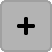
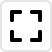
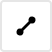
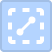
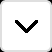
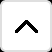
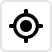
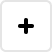
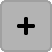
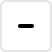
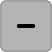
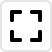
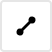
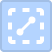
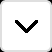
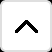
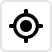

In [2]:
LetsPlot.setup_html()

In [3]:
data = {
    'x': [-10, -10, 10, 9, 11],
    'y': [-10, 10, -10, 9, 11],
    'w': [2, 4, 8, 1, 1],
}

In [4]:
identity_data = {
    'x': [-.5, .5, 0],
    'y': [0, 0, sqrt(3) / 2],
    'g': [1, 1, 2],
}

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/JetBrains/lets-plot-docs/refs/heads/master/data/mpg.csv")
print(df.shape)
df.head()

(234, 12)


Unnamed: 0 manufacturer model  displ  year  cyl       trans drv  cty  hwy  \
0           1         audi    a4    1.8  1999    4    auto(l5)   f   18   29   
1           2         audi    a4    1.8  1999    4  manual(m5)   f   21   29   
2           3         audi    a4    2.0  2008    4  manual(m6)   f   20   31   
3           4         audi    a4    2.0  2008    4    auto(av)   f   21   30   
4           5         audi    a4    2.8  1999    6    auto(l5)   f   16   26   

  fl    class  
0  p  compact  
1  p  compact  
2  p  compact  
3  p  compact  
4  p  compact

## Basic example with default stat

In [6]:
ggplot(df, aes("cty", "hwy")) + geom_hex()

## Basic example with `'identity'` stat

In [7]:
ggplot(identity_data, aes('x', 'y', fill='g')) + geom_hex(stat='identity')

## Aesthetics

In [8]:
gggrid([
    ggplot(data, aes('x', 'y')) + geom_hex(binwidth=[20, 20]) + geom_point(color='red') + ggtitle("Default"),
    ggplot(data, aes('x', 'y')) + geom_hex(width=.5, binwidth=[20, 20]) + geom_point(color='red') + ggtitle("width=.5"),
    ggplot(data, aes('x', 'y')) + geom_hex(height=.5, binwidth=[20, 20]) + geom_point(color='red') + ggtitle("height=.5"),
    ggplot(data, aes('x', 'y')) + geom_hex(aes(weight='w'), binwidth=[20, 20]) + geom_point(color='red') + ggtitle("weight='w'"),
    ggplot(data, aes('x', 'y')) + geom_hex(binwidth=[20, 20], alpha=.25) + geom_point(color='red') + ggtitle("alpha=.25"),
    ggplot(data, aes('x', 'y')) + geom_hex(binwidth=[20, 20], size=1, color='red') + geom_point(color='red') + ggtitle("size=2, color='red'"),
    ggplot(data, aes('x', 'y')) + geom_hex(aes(fill='..density..'), binwidth=[20, 20]) + geom_point(color='red') + ggtitle("fill='..density..'"),
], ncol=2)

## Problems

### Rupture at the place where the line is closed

In [9]:
ggplot(data, aes('x', 'y')) + \
    geom_hex(binwidth=[20, 20], size=5, color='red', alpha=0) + \
    coord_fixed(xlim=[-30, 30], ylim=[-30, 30])

### Does the sum of the density values have to be equal to one?

In [10]:
ggplot(data, aes('x', 'y')) + \
    geom_hex(aes(fill='..density..'), binwidth=[20, 20]) + \
    geom_point(color='red')

### Too much stretching of the hexagons

In [11]:
ggplot(data, aes('x', 'y')) + \
    geom_hex(binwidth=[10, 10]) + \
    geom_point(color='red')

In the plot above you can see that the hexagons are too big.

**Reason**: The statistics are fine, but the geometry is stretching the shapes with `ctx.getResolution()`. Because there are gaps in the data, and hexagons with zero `'count'` are skipped, the `resolution` is larger than it should be. `geom_bin2d()` does the same thing, but there it is not noticeable and is not a problem at all, since the rectangles join normally after stretching, not overlap. By the way, `resolution` will be calculated correctly if you just don't skip hexagons with zero `'count'` value:

In [12]:
ggplot(data, aes('x', 'y')) + \
    geom_hex(binwidth=[10, 10], drop=False) + \
    geom_point(color='red')

**Solution variants**:

- Do not remove missing hexagons from statistics, but do not draw them in geometry. But because of this there may be problems at the stage of range estimation for axes.

- Don't stretch the geometry based on `resolution`, but use another way to figure out what size the hexagons should be so they fit together. This probably means using the width and height computed in the statistic. Hence, width and height need to be passed in some aesthetics. Options:

  - `'width'`/`'height'`: if we use these aesthetics, firstly the "normalization" (the intuition that a value of 1 corresponds to placing geometries butt-to-butt) disappears, and secondly we have to rewrite the range estimation procedure for axes (for hexagons), since it uses `'width'`/`'height'` in a special way.

  - `'binwidth'`/`'binheight'`: will not work, because the name `'binwidth'` is already occupied by a function parameter.

  - Some new aesthetics - doubtful, but possible.

  General disadvantage of the approach: the already existing `geom_bin2d()` function works differently (stretches shapes using `resolution`), which means that when `stat='identity'` they will work differently, i.e. there will be a discrepancy in the API. On the other hand, maybe this is a reason to redo `geom_bin2d()`, since there is no stretching in ggplot2 either.